In [1]:
# directory /gpfs/gpfs0/deep/project/jupytertest2 = /localscratch_ssd/endrem/project/jupytertest2
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image, ExifTags

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, accuracy_score
import scipy

import matplotlib.pyplot as plt

#salmon-scales
#from train_util import read_images, load_xy, get_checkpoint_tensorboard, create_model_grayscale, get_fresh_weights, base_output, dense1_linear_output, train_validate_test_split


In [2]:
#!pip uninstall plotly -y
!pip install plotly --user
#!pip uninstall torch -y
#!pip install torch --user
#!pip install loguru --user
#!pip install timm --user #PyTorch Image Models
#!pip install albumentations  --user #augmentation
#!pip install colorama --user #color terminal

In [2]:
import os
import gc
import copy
import time
import random

import numpy as np
import pandas as pd
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

from tqdm import tqdm
from collections import defaultdict

from loguru import logger

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore
b_ = Fore.BLUE

from train_val_test_split import train_validate_test_split

### Train Configuration

In [3]:
# Source: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py
# tf_efficientnetv2_s_in21k - input_size=(3, 300, 300), test_input_size=(3, 384, 384)
# tf_efficientnetv2_m_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_l_in21k - input_size=(3, 384, 384), test_input_size=(3, 480, 480)
# tf_efficientnetv2_xl_in21k -input_size=(3, 384, 384), test_input_size=(3, 512, 512)

class CONFIG:
    seed = 42
    model_name = 'tf_efficientnetv2_l_in21k' 
    train_batch_size = 8
    valid_batch_size = 8
    img_size = 384
    val_img_size = 480
    learning_rate = 1e-5
    min_lr = 1e-6
    weight_decay = 1e-6
    T_max = 10
    scheduler = 'CosineAnnealingLR'
    n_accumulate = 1
    n_fold = 10 #5
    target_size = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    debugging = False
    which_exposure = "min"
    CHANNELS = "channels_first"
    KERAS_TRAIN_TEST_SEED = 2021
    ROOTDIR = "./EFFNetV2_l_MLP/"
    CUDA_VISIBLE_DEVICE = "0"
    #tensorboard_path = 'tensorboard_test2'
    #checkpoint_path = 'checkpoints_test2/cod_oto_efficientnetBBB.{epoch:03d}-{val_loss:.2f}.hdf5'
    input_shape = (3, img_size, img_size)
    test_size = 0.1 #0.15
    test_split_seed = 8
    steps_per_epoch = 160 #0
    epochs = 250
    early_stopping_patience = 14
    reduceLROnPlateau_factor = 0.2
    reduceLROnPlateau_patience = 7
    early_stopping = 25
    base_dir = '/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_08_12_2021/CodOtholiths-MachineLearning/Savannah_Professional_Practice'
    
    
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)    

In [5]:
import json

config_dict = CONFIG.__dict__
config_dict = dict(config_dict)
config_dict.pop('device', None)
config_dict.pop('__dict__', None)
config_dict.pop('__weakref__', None)
config_dict.pop('__doc__', None)

with open(CONFIG.ROOTDIR+'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_dict, f, ensure_ascii=False, indent=4)

### Read files to Pandas

In [6]:
from utils.read_jpg_cods import read_jpg_cods
from utils.train_val_test_split import *
from utils.train_test_split import *

CONFIG.debugging = False
df = read_jpg_cods( CONFIG ) #5316 #5110 #5150
#5110 images, after updating folder 2015: len age:5153 



error_count:226
add_count:5150


In [ ]:
CONFIG.img_size = CONFIG.val_img_size
df_test = read_jpg_cods( CONFIG ) 

### Train/Test split

In [113]:
print("len age:"+str( len(df.age) ) ) #len age:5090, error_count:205
train_imgs, train_age, test_imgs, test_age, test_path = train_test_split(df, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)
test_path.to_csv( CONFIG.ROOTDIR+"test_set_files.csv", index=False)
train_imgs2, train_age2, test_imgs2, test_age2, test_path2 = train_test_split(df_test, CONFIG, test_size=CONFIG.test_size, a_seed=CONFIG.test_split_seed)

print(np.any(test_path2==test_path))
print(np.any(test_age==test_age2))
test_imgs = test_imgs2

del train_imgs2
del test_imgs2
del train_age2
del test_age2
print(test_imgs.shape)

#df1 = pd.DataFrame(list(zip(train_imgs, train_age)), columns=['image', 'age'])

print(train_imgs.shape)
print(len(train_age))
print(test_imgs.shape)
print(len(test_age))
print(len(train_age)+len(test_age))
print(len(df))
#print(len(df1))

len age:5150
True
True
(515, 3, 480, 480)
(4635, 3, 384, 384)
4635
(515, 3, 480, 480)
515
5150
5150


print( train_imgs.shape )
print( type(train_imgs ))
print( type(train_age ))

a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    print( train_imgs_new.shape )
    print( train_age_new.shape )
    print( type( train_imgs_new ))
    print( type( train_age_new ))
    print( val_imgs_new.shape )
    print( val_age_new.shape )
    
    #print(train_imgs_new[0:5])
    print("#########################")
    #print(val_imgs_new[0:5])
    
    train_dataset = codDataset(train_imgs_new, train_age_new)
    valid_dataset = codDataset(val_imgs_new, val_age_new)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)

### Dataset class

In [248]:
class codDataset(Dataset):
    def __init__(self, imgs, age, transform=None): 
        self.labels = age 
        self.image = imgs #np.stack( df['image'].values , axis=0) # make 4D-array (num_imgs, channels, width, height)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.image[index]
        label = torch.tensor(self.labels[index]).float()
        
        #if self.transform:
            #print("1"+str(image.shape)) 
        #    tmp = image.transpose(1,2,0) # convert to channel last
            #print("2"+str(tmp.shape))
        #    image = self.transform(image=tmp)["image"] 
            #print("3"+str(image.shape))
        #    image = image.transpose(2,0,1)
            #print("4"+str(image.shape))
        
        return image, label

### Augmentation

In [219]:
data_transforms = {
    "train": A.Compose([
        A.ToGray(p=1.0)
    ]),
    "valid": A.Compose([], p=1.)
}

In [221]:
data_transforms = {
    "train": A.Compose([A.Affine(rotate=[45,45], p=1)]),
    "valid": A.Compose([], p=1.)
}

#### This one

In [235]:
data_transforms = {
    "train": A.Compose([A.Rotate((-90, 90), p=1.0)], p=0.99),
    "valid": A.Compose([], p=1.)
}

In [97]:
data_transforms = {
    "train": A.Compose([A.ShiftScaleRotate( shift_limit=0, scale_limit=0, rotate_limit=3, interpolation=0, p=1.0)]),
    "valid": A.Compose([], p=1.)
}

In [91]:
data_transforms = {
    "train": A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate( #shift_limit=0.01, #0.1, 
                           #scale_limit=0.0,  #0.15, 
                           rotate_limit=(-90, 90), 
                           p=0.5),
        #A.CoarseDropout(p=0.5),
        #A.Cutout(p=0.5),
        #ToTensorV2()], 
    ], p=1.),
    
    "valid": A.Compose([
        #A.Resize(CONFIG.img_size, CONFIG.img_size),
        #ToTensorV2()
    ], p=1.)
}

In [168]:
a =np.array([[[1, 2,1], [3, 4,1]]])
print(a.shape)
a = a.transpose(1,2,0)
#a = a.transpose(2,1,0)
print(a.shape)
print(a.transpose(2,0,1).shape)


(1, 2, 3)
(2, 3, 1)
(1, 2, 3)


  0%|          | 0/580 [00:00<?, ?it/s]


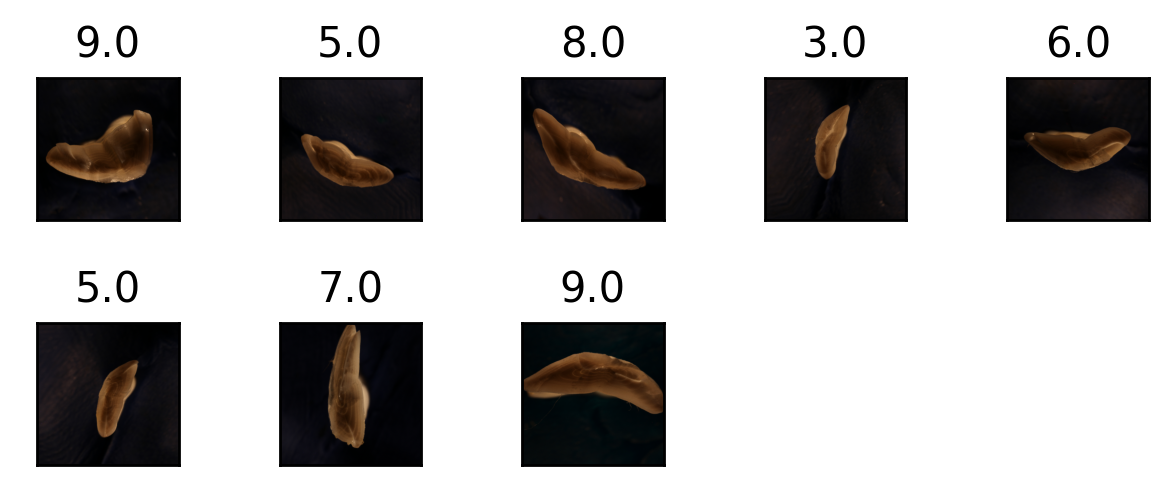

In [226]:
train_dataset = codDataset(train_imgs, train_age, data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)

plt.rcParams['figure.dpi'] = 250
bar = tqdm(enumerate(train_loader), total=len(train_loader))
i=0
fig = plt.figure(figsize=(5, 5))
plt.subplots_adjust(hspace = 2.0)
for step, (images, labels) in bar: 
    for j in range(0,8):
        fig.add_subplot(5, 5, j+1)
        tmp = images[j].detach().cpu().numpy()
        #print(images[j].shape)
        #print(tmp.shape)
        plt.imshow( tmp.transpose(1,2,0) )
        plt.title(f'{labels[j]}')
        plt.xticks([])
        plt.yticks([])
    
    break
    
plt.tight_layout()
plt.show()    

del train_loader
del train_dataset

train_dataset = codDataset(train_imgs, train_age, data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)

plt.rcParams['figure.dpi'] = 250
bar = tqdm(enumerate(train_loader), total=len(train_loader))
i=0
fig = plt.figure(figsize=(5, 5))
plt.subplots_adjust(hspace = 2.0)
j=1
#for step, (images, labels) in bar: 
for image in train_imgs:
    if i >= 8: 
        break
    else:
        
        fig.add_subplot(5, 5, j)
        j+=1
        to_aug = image.transpose(1,2,0)
        aug = data_transforms["train"](image=to_aug)["image"]
        plt.imshow( to_aug )
        plt.xticks([])
        plt.yticks([])
        
        fig.add_subplot(5, 5, j)
        j+=1
        plt.imshow( aug )
        plt.title(f'{labels[i]}')
        plt.xticks([])
        plt.yticks([])
        i+=1


plt.tight_layout()
plt.show()    

### Cod Model

In [249]:
class codModel(nn.Module):

    def __init__(self, model_name, pretrained=True):
        super(codModel, self).__init__()
        self.model = timm.create_model(CONFIG.model_name, pretrained=pretrained, in_chans=3, num_classes=1) #model_name
        self.n_features = self.model.classifier.in_features
        #self.model.classifier = nn.Linear(self.n_features, CONFIG.target_size)
        lastLayer = nn.Sequential(nn.Linear(self.n_features, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 32),
              nn.LeakyReLU(),
              nn.Linear(32, CONFIG.target_size))
        self.model.classifier = lastLayer
        print("model self:"+str(self.model.classifier))

    def forward(self, x):
        output = self.model(x)
        return output
    
model = codModel(CONFIG.model_name)
model.to(CONFIG.device);

model self:Sequential(
  (0): Linear(in_features=1280, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=32, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
#!pip install torchsummary
#from torchsummary import summary

#summary(model, (3, 384,384))


In [20]:
#model.eval()

### Training function

In [250]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar:  
        #optimizer.zero_grad()
        
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = torch.unsqueeze(labels, 1)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            #print("outputs:+"+str(outputs))
            #print("labels:"+str(labels))
            #print("mse:"+str(mean_squared_error(labels.cpu().data.numpy(), outputs.cpu().data.numpy())))
            loss = loss_fn(outputs, labels)
         
        
        scaler.scale(loss).backward() # Scales loss.  Calls backward() on scaled loss to create scaled gradients
        #model.print_debug() #model.classifier.weight[0:10,0]
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.        
        scaler.step(optimizer)
        scaler.update() # Updates the scale for next iteration.
            
        # zero the parameter gradients
        optimizer.zero_grad() # set_to_none=True here can modestly improve performance
                
        running_loss += loss.item() #(loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

### Test train function

def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

#for name, param in model.named_parameters():
#for param in model.parameters():
#    print(str( name ) +" "+ str(param.requires_grad))
train_dataset = codDataset(train_imgs, train_age, data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)

gc.collect()
train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

### Validation function

In [251]:
from sklearn.metrics import accuracy_score, mean_squared_error

@torch.no_grad()
def valid_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, labels) in bar: 
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.unsqueeze(labels, 1)
        outputs = model(images)
        loss = nn.MSELoss()(outputs, labels)
        
        batch_size = images.size(0)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss/dataset_size
        
        PREDS.append(outputs.cpu().detach().numpy())
        TARGETS.append(labels.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    PREDS = np.squeeze(PREDS)
    
    print("max:"+str(np.max( PREDS )))
    print("mean:"+str(np.mean( PREDS )))
    print("min:"+str(np.min( PREDS )))
    
    PREDS = PREDS.round()
    val_auc = accuracy_score(TARGETS, PREDS) #roc_auc_score(TARGETS, PREDS)
    mse_score = mean_squared_error(TARGETS, PREDS)
    print("acc:"+str( val_auc ) )
    print("mse:"+str( mse_score ) )
    gc.collect()
    
    return epoch_loss , val_auc

### Test validation

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)
epoch = 0
print(CONFIG.device)
print(CONFIG.epochs)

valid_dataset = codDataset(train_imgs[0:10], train_age[0:10], data_transforms["valid"]) 
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                          num_workers=0, shuffle=False, pin_memory=True)
gc.collect()
train_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler, 
                                   dataloader=train_loader, 
                                   device=CONFIG.device, epoch=epoch)

### Run

In [252]:
@logger.catch
def run(model, optimizer, scheduler, train_loader, valid_loader, fold_i):   
    device=CONFIG.device
    num_epochs=CONFIG.epochs
    patience = CONFIG.early_stopping
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auc = 0
    best_epoch = 0
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG.device, epoch=epoch)
        
        valid_epoch_loss, acc_score = valid_one_epoch(model, optimizer, scheduler,
                                                            dataloader=valid_loader, 
                                                            device=CONFIG.device, epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Valid AUC'].append(acc_score) #valid_epoch_auc)
        
        #print(f'Valid AUC: {valid_epoch_auc}')
        
        if scheduler is not None:
            scheduler.step()
        
        # deep copy the model
        if acc_score >= best_epoch_auc:
            print(f"{b_}Validation AUC Improved ({best_epoch_auc} ---> {acc_score})")
            best_epoch_auc = acc_score
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = CONFIG.ROOTDIR +"AUC{:.4f}_epoch{:.0f}_fold_{:.0f}.bin".format(best_epoch_auc, epoch, fold_i)
            torch.save(model.state_dict(), PATH)
            print("Model Saved")
            
        print()
        if best_epoch < epoch - patience:
            break
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUC: {:.4f}".format(best_epoch_auc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    #print(model.classifier.weight[0:10,0])
    
    return model, history, best_model_wts

### Train fold 0 to 5

#CONFIG.n_fold
CONFIG.epochs

In [253]:
from sklearn.metrics import accuracy_score, mean_squared_error

plt.rcParams['figure.dpi'] = 150

def fetch_scheduler(optimizer):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.T_0, T_mult=1, eta_min=CONFIG.min_lr)
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
scheduler = fetch_scheduler(optimizer)

print(CONFIG.device)
print(CONFIG.epochs)
#test_img = np.stack(df_test['image'].values  , axis=0)
#test_img = test_img * 1.0/255.0
print(type(test_imgs))
print(test_imgs.shape)
print(type(test_age))
print("#########")
print(type(train_imgs))
print(train_imgs.shape)

test_img = torch.from_numpy(test_imgs)
print("test_img shape:"+str( test_imgs.shape) )
print("test_img[0].shape:"+str( test_imgs[0].shape))
#test_img.to(CONFIG.device)

a_seed = CONFIG.KERAS_TRAIN_TEST_SEED #2021
numberOfFolds = CONFIG.n_fold #5
kfold = StratifiedKFold(n_splits=numberOfFolds, random_state=a_seed, shuffle=True)
#for i in range(0,5):
#CONFIG.epochs=5
test_15 = pd.DataFrame()
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, train_age.tolist())):
    #train_loader, valid_loader = prepare_data(fold=i)
    ######## K-FOLD Start #################
    train_imgs_new = train_imgs[train_idx]
    train_age_new = train_age[train_idx]
    val_imgs_new = train_imgs[val_idx]
    val_age_new = train_age[val_idx]
    
    train_dataset = codDataset(train_imgs_new, train_age_new, data_transforms["train"])
    valid_dataset = codDataset(val_imgs_new, val_age_new, data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    ######################### K-FOLD End #########################
    model, history, best_model_wts = run(model, optimizer, scheduler, train_loader, valid_loader, fold)

    fig = plt.figure(figsize=(5, 5))
    with torch.no_grad():
        PREDS_TEST  = []
        
        ceil_step = int(test_imgs.shape[0] / 25) + int(test_imgs.shape[0] % 25 > 0)
        for i in range(0, ceil_step):
            start_step = i * 25
            preds = model( torch.Tensor(test_imgs[start_step:start_step+25]).to(CONFIG.device) )
            preds = preds.cpu().detach().numpy()
            preds = preds.flatten()
            PREDS_TEST.extend(preds.tolist())
            
            if i == 0:
                fig = plt.figure(figsize=(5, 5))
                plt.subplots_adjust(hspace = 2.0)
                #test_imgs.shape[0]
                for j in range(0, 25):
                    fig.add_subplot(5, 5, j+1)
                    plt.imshow( test_imgs[j].transpose(1,2,0) )
                    plt.title(f'{preds[j]:.2f} ,{test_age[j]}')
                    plt.xticks([])
                    plt.yticks([])
                plt.tight_layout()
                plt.show()

        print("max:"+str(np.max( PREDS_TEST )))
        print("mean:"+str(np.mean( PREDS_TEST )))
        print("min:"+str(np.min( PREDS_TEST )))

        ROUNDED_PREDS_TEST = np.asarray(PREDS_TEST).round().astype('int')
        #print(ROUNDED_PREDS_TEST ) 
        #print(type(ROUNDED_PREDS_TEST))
        #print(ROUNDED_PREDS_TEST.shape)

        print("test mse:"+str( mean_squared_error(PREDS_TEST, test_age) )) 
        print("test acc:"+str( accuracy_score(ROUNDED_PREDS_TEST.tolist(), test_age.tolist() ) )) 
        print("PREDS TYPE:"+str(type(PREDS_TEST)))
        #print(PREDS_TEST.shape) ##list
        #print("PREDS:"+str(ROUNDED_PREDS_TEST))
        #print("TRUE:"+str(test_age))

        del model
        model = codModel(CONFIG.model_name)
        model.to(CONFIG.device);
        
        optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
        scheduler = fetch_scheduler(optimizer)
        test_15[str(fold)] = PREDS_TEST
        
test_15.to_csv(CONFIG.ROOTDIR+'preds.csv', index=False)

cuda:0
250
<class 'numpy.ndarray'>
(515, 3, 480, 480)
<class 'numpy.ndarray'>
#########
<class 'numpy.ndarray'>
(4635, 3, 384, 384)
test_img shape:(515, 3, 480, 480)
test_img[0].shape:(3, 480, 480)


  1%|          | 5/522 [00:03<05:49,  1.48it/s, Epoch=1, LR=1e-5, Train_Loss=4.41]
2022-01-12 10:57:29.546 | ERROR    | __main__:<module>:56 - An error has been caught in function '<module>', process 'MainProcess' (1575), thread 'MainThread' (140701138478912):
Traceback (most recent call last):

  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
                └ ModuleSpec(name='ipykernel_launcher', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7ff787fd4fd0>, origin='...
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <module> at 0x7ff78802c8a0, file "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 5>

  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
   

TypeError: 'NoneType' object is not iterable

In [254]:
del model
torch.cuda.empty_cache()

In [15]:
y_true = pd.read_csv(CONFIG.ROOTDIR+"test_set_files.csv")

from sklearn.metrics import accuracy_score, mean_squared_error
tmp = test_15["0"]+test_15["1"]+test_15["2"]+test_15["3"]+test_15["4"]+test_15["5"]+test_15["6"]+test_15["7"]+test_15["8"]+test_15["9"]
tmp = tmp/10
print(accuracy_score(tmp.values.round().astype("int"), y_true.age.values))
print(mean_squared_error(tmp.values, y_true.age.values))      

0.6621359223300971
0.3578598940821187


In [46]:
tmp = test_15["0"]+test_15["1"]+test_15["2"]+test_15["3"]+test_15["4"]+test_15["5"]+test_15["6"]+test_15["7"]+test_15["8"]+test_15["9"]
tmp = tmp/10
tmp.values.round().astype("int") - y_true.age.values

array([-1, -1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        1, -1, -1,  1,  1,  0,  0, -1,  0, -1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  1, -1,  0,  0,  0,
        1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  1, -2,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  1,  0, -1,  0,  1, -1, -2,  0, -1,  0, -1,  1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  1,  0,  0,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        0, -1,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  1,  1,  1,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  0, -1,  1,  0,  0,  0,  1,  0,  0,  1,  1,  0,  0,
        0,  0,  0, -1,  0,  1,  0,  0,  0,  1,  1,  0, -1, -1,  1,  0,  0,
        0,  0,  1,  1,  0

In [43]:
test_15["0"].values.round().astype("int")- y_true.age.values

array([-1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        2, -1,  0,  1,  1,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  2, -1,  1,  0,  0,
        1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  1, -2,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  1,  0, -1,  0,  1,  0, -2,  0, -1,  0, -1,  1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  0,  0,
        0, -1,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  1,  1,  1,  0,  0, -1,  0, -1,  1,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  1,  0,  0,  0,  1,  0,
        1,  0,  0,  0,  0, -1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,
        0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  1,  0, -1, -1,  0,  0,  0,
        0,  0,  1,  1,  0

In [44]:
test_15.values[0:10,:]

array([[ 8.40587425,  8.34830379,  8.36212158,  8.10772896,  8.61100864,
         8.3186245 ,  8.46316147,  8.27871799,  8.39489079,  8.5698967 ],
       [ 7.53432894,  7.75902557,  7.53156042,  7.16403055,  7.60321903,
         7.26473093,  7.26771879,  7.45926237,  7.26065731,  7.57685995],
       [ 8.10181522,  7.85581923,  7.88366652,  7.70696259,  7.95595312,
         7.95153379,  8.02853107,  7.91537046,  7.97012711,  7.84238529],
       [ 5.18091965,  5.11630678,  5.1250701 ,  4.81582689,  5.27573252,
         5.16714096,  5.25242186,  5.20822573,  5.10893488,  4.9312911 ],
       [11.30931568, 11.06189346, 11.25560665, 11.17534542, 11.0598793 ,
        11.05513477, 11.19380856, 11.22109222, 11.22600174, 11.04658222],
       [ 1.99435174,  2.20873308,  2.20724845,  2.13320541,  2.15963769,
         2.23518991,  2.1426549 ,  2.17996264,  2.05236435,  2.0339663 ],
       [ 4.69814777,  4.71426296,  4.81508732,  4.50243902,  4.70596647,
         4.73049498,  4.66153431,  4.70063162

In [45]:
tmp.values[0:10]

array([ 9.22662029,  8.19557228,  8.73139796,  5.63627901, 12.29139757,
        2.33416662,  5.1258884 ,  7.9805768 ,  3.04764116,  3.47526464])